In [37]:
from __future__ import division
import random

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix, make_scorer
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

from sklearn.model_selection import cross_val_score

%matplotlib inline
#!pip install sklearn
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import pickle

home_dir = '~/Documents/thesis/datasets/'


In [38]:
def balanced_subsample(x, y, subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            this_xs = this_xs.reindex(np.random.permutation(this_xs.index))

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = pd.concat(xs)
    ys = pd.Series(data=np.concatenate(ys),name='target')

    return xs, ys

In [39]:
def normalize_data(x):
    return (x - x.min(0)) / x.ptp(0)

In [40]:
def delete_columns_panda(pandaDataframe, blacklist):
    for element in blacklist:
        del pandaDataframe[element]
    return pandaDataframe

In [41]:
def preprocess_data(data):
    data = data.replace("na", 0)
    data = data.replace("neg", 0)
    data = data.replace("pos", 1)

    return data

In [42]:
def reset_data(with_undersampling=False):
    
    # our training and test datasets
    X_train = pd.read_csv(home_dir + 'scania/training_set_new.csv')
    X_test = pd.read_csv(home_dir + 'scania/test_set_new.csv') 
    
    # "live data" dataset
    live_test = pd.read_csv(home_dir + 'scania/aps_failure_test_set.csv') 
    
     
    X2_train = pd.read_csv(home_dir + 'scania/live_training_set.csv')  

    
    X_train = preprocess_data(X_train)
    X_test = preprocess_data(X_test)
    X2_train = preprocess_data(X2_train)
    
    y_train = X_train.iloc[:, 0]  # First column in labels
    y_test = X_test.iloc[:, 0]  # First column in labels
    y2_test = X2_train.iloc[:, 0]  # First column in labels

    X_train = X_train.drop(X_train.columns[0], axis=1)  # delete first column of xtrain
    X_test = X_test.drop(X_test.columns[0], axis=1)  # delete first column of xtest
    X2_train = X2_train.drop(X2_train.columns[0], axis=1)  # delete first column of xtest
    
    if with_undersampling:
        X_train, y_train = balanced_subsample(X_train, y_train)
        
    return X_train, X_test, X2_train, y_train, y_test, y2_test

In [43]:
def write_predictions_to_file(filename, data):
    f = open(filename, 'w')
    f.write('id,label\n')
    i = 1
    for item in data:
        f.write('%s' % i)
        f.write(',')
        f.write('%s' % int(item))
        f.write('\n')
        i = i+1
    f.close()

In [44]:
def find_cost(predictions, X_train, X_test, y_train, y_test):
    cost_1_instances = 0
    cost_2_instances = 0
    normal_correct = 0
    anomaly_correct = 0
    for i in range(0, len(predictions)):
        if predictions[i] == 0 and y_test[i] == 1:  # He predicted normal but it was anomaly
            cost_2_instances += 1
        elif predictions[i] == 1 and y_test[i] == 0:  # He predicted anomaly but it was normal
            cost_1_instances += 1
        elif predictions[i] == 0 and y_test[i] == 0: # He predicted normal and it was normal
            normal_correct += 1
        elif predictions[i] == 1 and y_test[i] == 1: # He predicted anomaly and it was anomaly
            anomaly_correct += 1

    print (("cost_1_instances are {}".format(cost_1_instances)))
    print (("cost_2_instances are {}".format(cost_2_instances)))
    print (("Correct normal predictions are {}".format(normal_correct)))
    print (("Correct anomaly predictions are {}".format(anomaly_correct)))
    print (("Total Cost is {}".format(10*cost_1_instances + 500*cost_2_instances)))
    

In [45]:
def feature_selection(X_train,y_train, num_of_features, X_test, y_test):
# Build RF classifier to use in feature selection
    knn = KNeighborsClassifier(n_neighbors=3)

    #create new scoring parameter based on cost function
    cost = make_scorer( find_cost, greater_is_better= False)
    # Build step forward feature selection
    sfs1 = sfs(knn,
               k_features= num_of_features,
               forward=True,
               floating=False,
               verbose=2,
               scoring=cost,
               cv=0)

    # Perform SFFS
    sfs1 = sfs1.fit(X_train, y_train)
    predictions = sfs1.predict(X_test)

    feat_cols = list(sfs1.k_feature_idx_)
    print(feat_cols)
    
    return feat_cols

In [46]:
def execute_classifier(use_training, clf, X_train, X_test, y_train, y_test, name):

    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    # predictions = np.round(predictions)

    
    
    if not use_training:
        return predictions
    else:
        prediction_prob = clf.predict_proba(X_test)
        predictions = []
        true_labels = []
        for pr in prediction_prob:
            if pr[0] > 0.95:
                predictions.append(0)  # Neg
            else:
                predictions.append(1)  # Pos

        accuracy = 0
        for i in range(0, len(predictions)):
            if predictions[i] == y_test[i]:
                accuracy +=1
                
                
        conf_mat = confusion_matrix(y_test, predictions)        
        average_precision = average_precision_score(y_test, predictions)
        
        #find average precision recall
        print('Average precision-recall score: {0:0.2f}'.format(average_precision))
        precision, recall, _ = precision_recall_curve(y_test, predictions)

        #plot precision recall

        precision, recall, _ = precision_recall_curve(y_test, predictions)

        plt.step(recall, precision, color='b', alpha=0.2,
                 where='post')
        plt.fill_between(recall, precision, step='post', alpha=0.2,
                         color='b')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
                  average_precision))

        write_predictions_to_file(name + '_output.csv.dat', y_test)
        find_cost(predictions, X_train, X_test, y_train, y_test)
        # print ("Accuracy of {} is {} %".format(name, round((accuracy)*100, 5)))

        return predictions, accuracy/len(predictions)

In [47]:
# Getting the data from the csv files
X_train, X_test, X2_train, y_train, y_test, y2_test = reset_data(with_undersampling=False) 

Average precision-recall score: 0.36
cost_1_instances are 195
cost_2_instances are 67
Correct normal predictions are 14555
Correct anomaly predictions are 183
Total Cost is 35450
Average precision-recall score: 0.43
cost_1_instances are 211
cost_2_instances are 96
Correct normal predictions are 15414
Correct anomaly predictions are 279
Total Cost is 50110
Accuracy of KNeighborsClassifier is 98.25333 %
Accuracy of KNeighborsClassifier live is 98.08125 %


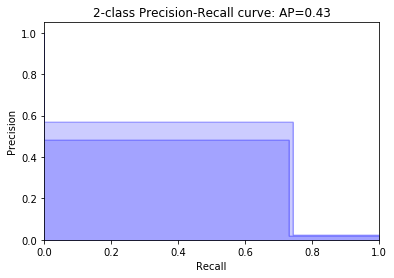

In [48]:
# Define "classifiers" to be used

classifiers = {

    "KNeighborsClassifier": KNeighborsClassifier(3)
}

# executing each classifier

for name, classifier in classifiers.items():
    #feat_cols = feature_selection(X_train,y_train, i,  X_test, y_test)
    feat_cols = [8, 37, 38, 70, 75]

    x_train_less_feat = X_train.iloc[:, feat_cols]
    x_test_less_feat = X_test.iloc[:, feat_cols]
    x2_train_live = X2_train.iloc[:, feat_cols]
    
    # predictions after feature reduction
    predictions_tocompare, accuracy_tocompare = execute_classifier(True, classifier, x_train_less_feat, x_test_less_feat, y_train, y_test, name=name)
   
    predictions_live, accuracy_live = execute_classifier(True, classifier, x_train_less_feat, x2_train_live, y_train, y2_test, name=name)
    
    # new model is trained with live data 
    # missing test data for the new model
    #predictions_eval_model, accuracy_eval_model = execute_classifier(True, classifier, x2_train_live, ???,  y2_test, ???, name=name)
   

    print ("Accuracy of {} is {} %".format(name, round((accuracy_tocompare)*100, 5)))
    print ("Accuracy of {} live is {} %".format(name, round((accuracy_live)*100, 5)))
    #print ("Accuracy of {} the evaluation model is {} %".format(name, round((accuracy_eval_model)*100, 5)))    


In [49]:
X_test.shape

(15000, 170)